In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
NUM_EPOCH = 10

class ResNet50_CIFAR(nn.Module):
    def __init__(self):
        super(ResNet50_CIFAR, self).__init__()
        # Initialize ResNet 50 with ImageNet weights
        ResNet50 = models.resnet50(pretrained=True)
        modules = list(ResNet50.children())[:-1]
        backbone = nn.Sequential(*modules)
        # Create new layers
        self.backbone = nn.Sequential(*modules)
        self.fc1 = nn.Linear(2048, 32)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, img):
        # Get the flattened vector from the backbone of resnet50
        out = self.backbone(img)
        # processing the vector with the added new layers
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        return self.fc2(out)

def train(trainloader):
    ## Create model, objective function and optimizer
    model = ResNet50_CIFAR()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(list(model.fc1.parameters()) + list(model.fc2.parameters()),
                           lr=0.001, momentum=0.9)

    ## Do the training
    for epoch in range(NUM_EPOCH):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 20 == 19:    # print every 20 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 20))
                running_loss = 0.0
    print('Finished Training')
    return model


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

## Define the training dataloader
transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10('./data', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                      shuffle=True, num_workers=2)

def imshow(img, num):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if not os.path.exists("Images"):
        os.makedirs("Images")
    plt.savefig("Images\Image" + str(num) + ".png")
    
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


In [5]:
import os
if not os.path.exists("419a2_model.pt"): 
    model = train(trainloader)
    torch.save(model.state_dict(), "419a2_model.pt")

In [6]:
model = ResNet50_CIFAR()
model.load_state_dict(torch.load("419a2_model.pt"))
model.to(device)

ResNet50_CIFAR(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 25

 deer truck plane  ship


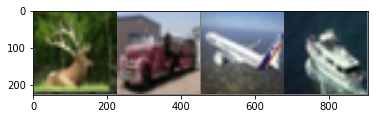

In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images), -1)

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


Predicted:    dog  ship truck plane
GroundTruth:    cat  ship  ship plane


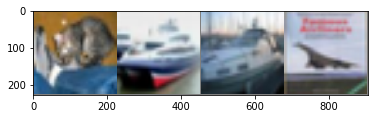

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images), -1)

images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
# #         imshow(torchvision.utils.make_grid(images))

#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         print("Currect = %d, total = %d" %(correct, total))

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
all_predicted = []
k = 1
with torch.no_grad():
    print("Producting the first 100 sample images and Calculating Scores of Classification on 10000 test images ......")
    produce_image = True
    if not os.path.exists("Images"):
        os.makedirs("Images")
    if os.path.exists("Images/Image100.png"):
        produce_image = False
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        # save the first images in Images
        if k <= 100 and produce_image == True:
            imshow(torchvision.utils.make_grid(images.cpu()), k)
            k += 1
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predicted.append(predicted)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Producting the first 100 sample images and Calculating Scores of Classification on 10000 test images ......
Accuracy of plane : 62 %
Accuracy of   car : 69 %
Accuracy of  bird : 44 %
Accuracy of   cat : 46 %
Accuracy of  deer : 62 %
Accuracy of   dog : 54 %
Accuracy of  frog : 63 %
Accuracy of horse : 78 %
Accuracy of  ship : 70 %
Accuracy of truck : 76 %


In [34]:
f = open('output.html','w')
message = """<html>
<head >
    <title>CMPT419 Model Prediction and Scores of Classification</title>
    <p1 style="font-size:24px">CMPT419 Model Prediction and Scores of Classification</p1>
    <style>

    p2 {
    font-size: 15px;
    color: white;
    }
    
    .txt {
    font-size:15px;
    margin: 10px 0 10px 75px;
    position: relative;
    }
    .crop {
    width: 800px;
    height: 250px;
    overflow: hidden;
    }

    .crop img {
    width: 600px;
    height: 60%;
    margin: -10px 10px -10px 65px;
    object-fit: cover;
    }
    </style>
</head>
<body>
"""
score = 0
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    message = message+ '<p style="margin:0 0 0 30px">Accuracy of %5s : %2d %%</p>' % (classes[i], accuracy)
    score += accuracy
    
message += '<p style="font-size:20px"><b>Classification Score: %2d %%</b></p>' % (score/10)
message += """<div style="font-size:22px"> 100 sample predictions </p1>"""
dataiter = iter(testloader)
for i in range(100):
    images, labels = dataiter.next()
    message += """<div class="crop">"""+ "<img src=" + "Images/Image" + str(i+1) + ".png" + """ align="middle">"""
    message += """<div class="txt">"""+ str(i+1) + """&nbsp;&nbsp;Predicted:&nbsp;&nbsp;""" 
    for j in range(4):
        label = labels[j]
        if all_predicted[i][j].cpu() == label:
            message += """&nbsp;&nbsp;&nbsp; <p2 style="background-color: green;">""" +  classes[all_predicted[i][j]] + "</p2>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"
        else:
            message += """&nbsp;&nbsp;&nbsp; <p2 style="background-color: red;">""" + classes[all_predicted[i][j]] + "</p2>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"

    message += "</div>" +"""</div>"""
message += """
</body>
</html>"""
f.write(message)
f.close()

In [33]:
import webbrowser
webbrowser.open_new_tab("output.html")

True